The code is based on the workflow presented in https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline_jax.ipynb.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import json
import os
import glob
from pathlib import Path
import numpy as np
import pickle

from discopy.utils import loads
from pytket.extensions.qiskit import AerBackend
from lambeq import NumpyModel
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import Dataset

from jax import numpy as np
import numpy

this_folder = os.path.abspath(os.getcwd())
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

BATCH_SIZE = 32
EPOCHS = 1000
SEED = 0

In [2]:
training_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//training//[0-9]*.p")
#validation_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//validation//[0-9]*.p")
test_circuits_paths = glob.glob(this_folder + "//simplified-JOB-diagrams//circuits//binary_classification//test//[0-9]*.p")

def read_diagrams(circuit_paths):
    circuits = {}
    for serialized_diagram in circuit_paths:
        base_name = Path(serialized_diagram).stem
        f = open(serialized_diagram, "rb")
        diagram = pickle.load(f)
        circuits[base_name] = diagram
    return circuits


training_circuits = read_diagrams(training_circuits_paths) #+ training_circuits_paths[21:])
for key in training_circuits:
    print("training query: ", key)
test_circuits = read_diagrams(test_circuits_paths) #+ [test_circuits_paths[2]] + test_circuits_paths[8:])
#test_circuits = read_diagrams([test_circuits_paths[2]])
for key in test_circuits:
    print("test query: ", key)

training query:  5b
training query:  7c
training query:  9e
training query:  9d
training query:  6d
training query:  7b
training query:  6b
training query:  5d
training query:  10b
training query:  1b
training query:  9c
training query:  9b
training query:  1c
training query:  10d
training query:  10c
training query:  2d
training query:  11b
training query:  11c
training query:  8b
training query:  2c
training query:  2b
training query:  5c
training query:  7d
training query:  6c
training query:  7e
test query:  2a
test query:  7a
test query:  4a
test query:  9a
test query:  11a
test query:  5a
test query:  8a
test query:  6a
test query:  10a
test query:  1a


In [3]:
training_data, test_data = None, None
with open(this_folder + "//data//training_data.json", "r") as inputfile:
    training_data = json.load(inputfile)['training_data']
with open(this_folder + "//data//test_data.json", "r") as inputfile:
    test_data = json.load(inputfile)['test_data']
    

def time_to_states(data):
    labeled_data = {}
    for elem in data:
        if elem["name"] in training_circuits.keys() or elem["name"] in test_circuits.keys():
            if elem["time"] < 2001:
                labeled_data[elem["name"]] = [1., 0.] # corresponds to |0>
            else:
                labeled_data[elem["name"]] = [0., 1.] # corresponds to |1>
    return labeled_data


training_data_labels = time_to_states(training_data)
test_data_labels = time_to_states(test_data)

#for key in training_data_labels:
#    print("training: ", key)
#for key in test_data_labels:
#    print("test ", key)

In [4]:
training_circuits_l = []
test_circuits_l = []
training_data_labels_l = []
test_data_labels_l = []

for key in training_circuits:
    training_circuits_l.append(training_circuits[key])
    training_data_labels_l.append(training_data_labels[key])

for key in test_circuits:
    test_circuits_l.append(test_circuits[key])
    test_data_labels_l.append(test_data_labels[key])

all_circuits = training_circuits_l + test_circuits_l

train_syms = set([sym for circuit in training_circuits.values() for sym in circuit.free_symbols])
test_syms = set([sym for circuit in test_circuits.values() for sym in circuit.free_symbols])

print("Test circuits need to share training circuits' parameters. The parameters that are not covered: ", test_syms.difference(train_syms))

print("Total number of circuits: ", len(all_circuits))
print("Total number of variables: ", len([sym for circuit in all_circuits for sym in circuit.free_symbols]))

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
model.initialise_weights()

Test circuits need to share training circuits' parameters. The parameters that are not covered:  {name_pcode_cf__n.l_0, 'D%'__n.l_0, company_name__n.l_0, 'features'__n.l_0, FROM_n@n.l@n.l@n.l@n.l@n.l_n_1, FROM_n@n.l@n.l@n.l@n.l@n.l_n_2, FROM_n@n.l@n.l@n.l@n.l@n.l_n_0, name_pcode_cf__n.l_2, FROM_n@n.l@n.l@n.l@n.l@n.l_n_3, 'D%'__n.l_2, company_id__n.l_0, name_pcode_cf__n.l_1, company_name__n.l_1, company_name__n.l_2, 'D%'__n.l_1, 'features'__n.l_2, company_id__n.l_1, FROM_n@n.l@n.l@n.l@n.l@n.l_n_4, company_id__n.l_2, 'features'__n.l_1}
Total number of circuits:  35
Total number of variables:  1158


In [5]:
loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
#acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

def acc(y_hat, y):
    #print(type(y_hat), type(y))
    #print("y_hat: ", np.round(y_hat))
    #print("y: ", y)
    #print(np.sum(np.round(y_hat) == np.round(y)))
    return np.sum(np.round(y_hat) == y) / len(y) / 2
    
eval_metrics = {"acc": acc}

In [6]:
trainer = QuantumTrainer(
    model,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 3.6, 'A':0.01*EPOCHS},
    evaluate_functions=eval_metrics,
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

In [7]:
train_dataset = Dataset(
            training_circuits_l,
            training_data_labels_l)

test_dataset = Dataset(test_circuits_l, test_data_labels_l, shuffle=False)

trainer.fit(train_dataset, test_dataset, evaluation_step=1, logging_step=100)

Epoch 1:     train/loss: 0.6484   valid/loss: 0.6921   train/acc: 0.6000   valid/acc: 0.4000
Epoch 100:   train/loss: 0.7069   valid/loss: 0.6921   train/acc: 0.5200   valid/acc: 0.4000
Epoch 200:   train/loss: 0.7086   valid/loss: 0.6921   train/acc: 0.4800   valid/acc: 0.4000
Epoch 300:   train/loss: 0.6933   valid/loss: 0.6921   train/acc: 0.4800   valid/acc: 0.4000
Epoch 400:   train/loss: 0.6929   valid/loss: 0.6921   train/acc: 0.4800   valid/acc: 0.4000
Epoch 500:   train/loss: 0.6944   valid/loss: 0.6921   train/acc: 0.6000   valid/acc: 0.4000
Epoch 600:   train/loss: 0.7116   valid/loss: 0.6921   train/acc: 0.4800   valid/acc: 0.4000
Epoch 700:   train/loss: 0.6972   valid/loss: 0.6921   train/acc: 0.6000   valid/acc: 0.4000
Epoch 800:   train/loss: 0.7021   valid/loss: 0.6921   train/acc: 0.5200   valid/acc: 0.4000
Epoch 900:   train/loss: 0.6978   valid/loss: 0.6921   train/acc: 0.6000   valid/acc: 0.4000
Epoch 1000:  train/loss: 0.7541   valid/loss: 0.6921   train/acc: 0.40

[0.50112116 0.49887884]
[0.50554323 0.49445683]
[0.51459616 0.4854038 ]
[0.51459587 0.48540416]
[0.514596   0.48540395]
[0.5011213  0.49887875]
[0.51459605 0.48540398]
[0.514596   0.48540407]
[0.51459605 0.48540398]
[0.51459605 0.48540393]
[0.0, 1.0]
[0.0, 1.0]
[0.0, 1.0]
[1.0, 0.0]
[1.0, 0.0]
[0.0, 1.0]
[0.0, 1.0]
[1.0, 0.0]
[0.0, 1.0]
[1.0, 0.0]
Validation accuracy: 0.4


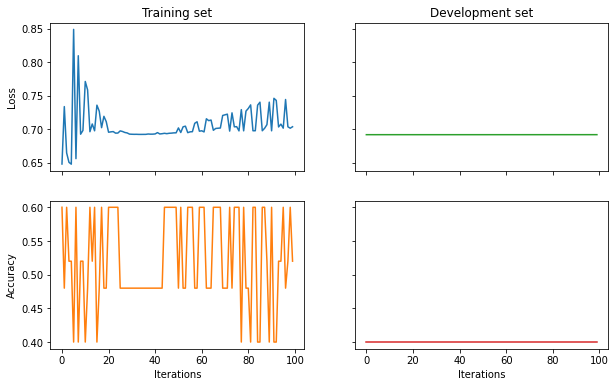

In [8]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer.train_epoch_costs[::10], color=next(colours))
ax_bl.plot(trainer.train_results['acc'][::10], color=next(colours))
ax_tr.plot(trainer.val_costs[::10], color=next(colours))
ax_br.plot(trainer.val_results['acc'][::10], color=next(colours))

for e in model(test_circuits_l):
    print(e)
for e in test_data_labels_l:
    print(e)
# print test accuracy
test_acc = acc(model(test_circuits_l), np.array(test_data_labels_l))
print('Validation accuracy:', test_acc)